In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip,
                                    RandomResizedCrop, Resize, ToTensor)
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
import pandas as pd
from PIL import Image
import numpy as np
import os

In [9]:
TRAIN_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Train'
VALIDATE_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Validate'
TEST_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Test'

TRAIN_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET-clean/FOOD-DATASET/TRAIN'
VALIDATE_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET-clean/FOOD-DATASET/VAL'
TEST_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET-clean/FOOD-DATASET/TEST'

In [3]:
def create_dataframe(base_path):
    data = []
    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):
                    data.append([img_path, class_name])
    return pd.DataFrame(data, columns=['filename', 'class'])

In [10]:
# Merge DataFrames
df_train = pd.concat([create_dataframe(TRAIN_PATH_30VNFOODS), create_dataframe(TRAIN_PATH_CUSTOMDATA)])
df_validate = pd.concat([create_dataframe(VALIDATE_PATH_30VNFOODS), create_dataframe(VALIDATE_PATH_CUSTOMDATA)])
df_test = pd.concat([create_dataframe(TEST_PATH_30VNFOODS), create_dataframe(TEST_PATH_CUSTOMDATA)])

# Reset indices
df_train.reset_index(drop=True, inplace=True)
df_validate.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [11]:
# Get unique classes
all_classes = pd.concat([df_train['class'], df_validate['class'], df_test['class']]).unique()
num_labels = len(all_classes)
id2label = {id:label for id, label in enumerate(all_classes)}
label2id = {label:id for id, label in id2label.items()}

In [12]:
model_name = "google/vit-large-patch16-384"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name,
                                                  num_labels=num_labels,
                                                  id2label=id2label,
                                                  label2id=label2id,
                                                  ignore_mismatched_sizes=True)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([38, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([38]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from torchvision.transforms import RandomHorizontalFlip

class FoodDataset(Dataset):
    def __init__(self, dataframe, processor, is_train=True):
        self.dataframe = dataframe
        self.processor = processor
        self.is_train = is_train
        self.random_flip = RandomHorizontalFlip(p=0.5) if is_train else None

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filename']
        image = Image.open(img_path).convert('RGB')

        # Apply random flip for training if enabled
        if self.is_train and self.random_flip:
            image = self.random_flip(image)

        # Use processor for preprocessing
        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in inputs.items()}

        label = label2id[self.dataframe.iloc[idx]['class']]
        inputs['labels'] = torch.tensor(label)

        return inputs

In [14]:
# Create datasets
train_dataset = FoodDataset(df_train, processor, is_train=True)
val_dataset = FoodDataset(df_validate, processor, is_train=False)

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

In [22]:
training_args = TrainingArguments(
    output_dir="./vit-l-16-food-classifier",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=True,
    report_to='none',
    gradient_accumulation_steps=4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.413755,0.899891
2,0.817900,0.348246,0.915125
3,0.817900,0.321362,0.915488


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparenc

TrainOutput(global_step=879, training_loss=0.5103478936205138, metrics={'train_runtime': 13277.6451, 'train_samples_per_second': 4.237, 'train_steps_per_second': 0.066, 'total_flos': 4.534902001025306e+19, 'train_loss': 0.5103478936205138, 'epoch': 3.0})

In [24]:
!pip install evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 841.1 kB/s eta 0:00:000:00:01


In [25]:
import evaluate

metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")

# Get predictions on the validation set
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [28]:
# Generate classification report
class_names = list(label2id.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Use the actual class names for tick labels
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

print("Confusion matrix saved as 'confusion_matrix.png'")

# If you want to print the confusion matrix values
print("\nConfusion Matrix:")
print(cm)


Classification Report:
                  precision    recall  f1-score   support

       Banh cuon       0.92      0.96      0.94       114
        Mi quang       0.94      0.99      0.96        89
Banh trang nuong       0.89      0.94      0.91        80
        Goi cuon       0.95      0.96      0.96        85
        Banh gio       0.89      0.88      0.88        64
         Bun mam       0.94      0.88      0.91        77
       Canh chua       0.90      0.93      0.91        83
        Nem chua       0.94      0.83      0.88        54
        Bun rieu       0.89      0.89      0.89       115
        Banh duc       0.81      0.83      0.82        66
        Banh pia       0.96      0.98      0.97        45
       Banh canh       0.80      0.84      0.82        97
       Banh khot       0.91      0.95      0.93        84
    Banh bot loc       0.93      0.86      0.89        73
        Banh can       0.93      0.95      0.94        75
  Bun thit nuong       0.93      0.95      0.94

In [29]:
from huggingface_hub import notebook_login

notebook_login()

In [30]:
trainer.push_to_hub()

events.out.tfevents.1722497279.dc0acc75bf45.34.0:   0%|          | 0.00/6.63k [00:00<?, ?B/s]

events.out.tfevents.1722497326.dc0acc75bf45.34.1:   0%|          | 0.00/6.63k [00:00<?, ?B/s]

events.out.tfevents.1722497336.dc0acc75bf45.34.2:   0%|          | 0.00/6.63k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/VietTung04/vit-l-16-food-classifier/commit/920aa0a7421f061310789a23b3d7ccd7c334ebb5', commit_message='End of training', commit_description='', oid='920aa0a7421f061310789a23b3d7ccd7c334ebb5', pr_url=None, pr_revision=None, pr_num=None)

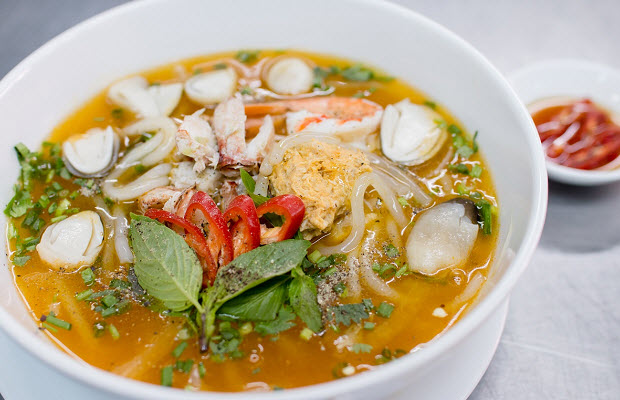

In [32]:
from PIL import Image

image = Image.open("/kaggle/input/vietnamese-foods/Images/Test/Banh canh/110.jpg")
image

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Banh canh


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from huggingface_hub import InferenceClient
client = InferenceClient("VietTung04/vit-l-16-food-classifier/")

In [5]:
link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSHpX1WU1BcfboB0SnHzTRbbeU67A7HdRGTGw&s'

client.image_classification(link)

[ImageClassificationOutputElement(label='Pho', score=0.9893237948417664),
 ImageClassificationOutputElement(label='Canh chua', score=0.002417229814454913),
 ImageClassificationOutputElement(label='Hu tieu', score=0.0019367773784324527),
 ImageClassificationOutputElement(label='Bun bo Hue', score=0.0010912305442616343),
 ImageClassificationOutputElement(label='Bún cá', score=0.0008956494275480509)]